# <font color=#214B99>Projet 9 - Réalisez une application de recommandation de contenu</font>

># <font color=#9E025C> Partie 2 : Modélisation et évaluation</font>

<img src="https://user.oc-static.com/upload/2019/10/24/15719078448088_Capture%20d%E2%80%99e%CC%81cran%202019-10-24%20a%CC%80%2010.50.32.png" alt="Logo My Content">

## <font color=#009BFA> Plan :</font>
- **Partie 1 : Analyse et préparation des données**
- **Partie 2 : Modélisation et évaluation**  
>1. [**Chargement des bibliothèques**](#section_1)
>2. [**Chargement du jeu de données**](#section_2)
>3. [**Content-Based Filtering**](#section_3)
>4. [**Collaborative-based Filtering**](#section_4)
>5. [**Conclusion**](#section_5)
>6. [**Sauvegarde dans Azure**](#section_6)

## <font color=#650093 >Introduction </font>
Les systèmes de recommandation peuvent être définis de plusieurs façons, vue la diversité des classifications proposées pour ces systèmes qui peuvent se rapporter à différents types de données ou approches spécifiques, mais il existe une définition générale de Robin Burke`[1]` qui correspond à notre cas d'étude :</br>
**Des systèmes capables de fournir des recommandations personnalisées permettant de guider l’utilisateur vers des ressources intéressantes et utiles au sein d’un espace de données important**.<br> 

L'utilisateur voit ainsi son temps de recherche réduit. L’essor du Web et sa popularité ont notamment contribué à la mise en place de tels systèmes comme dans le domaine du e-commerce.<br>
Les applications de recommandation peuvent être trouvé dans une grande variété d’industries,
entreprises, service financier, musique / radio en ligne, TV et vidéos, les publications en ligne,
et d’innombrables autres.<br>
Les approches classiques des systèmes de recommandation sont :
- le filtrage collaboratif : utilise les similarités entre les utilisateurs, 
- le filtrage basé sur le contenu : utilise les informations liées aux caractéristiques des produits. 
- l'approche hybride : elle résulte de la combinaison des deux approches précédentes et dont le but est de tirer profit des atouts de chacune. [Article ici](https://hal.inria.fr/hal-03591997v2/document)

L’une des tâches les plus populaires dans le domaine des systèmes de recommandation est la recommandation top-N. Dans ce cas, le système propose une liste ordonnée de N produits les plus probables d’avoir l’attention de l’utilisateur. Dans notre cas les produits sont des articles et la valeur de N est égale à 5.

`[1]`: <span style='color:#565A55'> Burke, R. Hybrid recommender systems: Survey and experiments. User Modeling and User-Adapted Interaction, 12(4) :331–370, 2002.</span>

**Définition:** Le démarrage à froid (cold-start problem) est rencontré lorsque les recommandations sont nécessaires pour des éléments ou des utilisateurs pour lesquels nous n’avons aucune information explicite ou implicite. Il y a donc deux problèmes liés au démarrage à froid : nouvel utilisateur et nouvel élément.

# <span style='color:#DC6000 ' id="section_1" >1. Chargement des bibliothèques</span>

In [2]:
import os
import logging
import random
from datetime import datetime
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib as plt
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import implicit
from implicit.evaluation import precision_at_k, train_test_split, ranking_metrics_at_k, mean_average_precision_at_k
from scipy import sparse
from scipy.sparse import csr_matrix
pd.options.plotting.backend = 'matplotlib' #"plotly"

In [3]:
import warnings
warnings.filterwarnings('ignore')

# <span style='color:#DC6000 ' id="section_2" >2. Chargement du jeu de données</span>

In [4]:
DATA_PATH = "../../00_P9_dataset/news-portal-user-interactions-by-globocom"

>## <font color=#1800C8 >Chargement des fichiers `clicks`</font>

In [5]:
if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "../../00_P9_dataset/news-portal-user-interactions-by-globocom/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Nombre de fichiers clicks csv:", len(clicks_path))

    list_clicks_df = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        list_clicks_df.append(df)

    df_clicks = pd.concat(list_clicks_df, axis=0, ignore_index=True)
    df_clicks.to_csv('clicks.csv', index=False)
else:
    df_clicks = pd.read_csv('clicks.csv')

In [6]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype
---  ------               -----
 0   user_id              int64
 1   session_id           int64
 2   session_start        int64
 3   session_size         int64
 4   click_article_id     int64
 5   click_timestamp      int64
 6   click_environment    int64
 7   click_deviceGroup    int64
 8   click_os             int64
 9   click_country        int64
 10  click_region         int64
 11  click_referrer_type  int64
dtypes: int64(12)
memory usage: 273.6 MB


In [7]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [8]:
df_clicks_clean = df_clicks[['user_id', 'session_id', 'session_size', 'click_article_id']]
df_clicks_clean.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


In [9]:
df_clicks_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 4 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   session_id        int64
 2   session_size      int64
 3   click_article_id  int64
dtypes: int64(4)
memory usage: 91.2 MB


### Suppression des utilisateurs ayant moins de N clicks sur des articles

In [10]:
NB_CLICK_MIN_BY_USER = 3

In [11]:
df_clicks_per_users_count = df_clicks_clean.groupby(['user_id']).size()

In [12]:
df_users_with_enough_clicks = df_clicks_per_users_count[df_clicks_per_users_count >= NB_CLICK_MIN_BY_USER].reset_index()[['user_id']]

In [13]:
df_users_with_enough_clicks

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
221464,322864
221465,322870
221466,322879
221467,322881


In [14]:
nb_unique_users_with_enough_clicks = df_users_with_enough_clicks['user_id'].nunique()
print(f"Number of unique users with a minimum of {NB_CLICK_MIN_BY_USER} clicks = {nb_unique_users_with_enough_clicks}")

Number of unique users with a minimum of 3 clicks = 221469


In [15]:
df_min_clicks_clean = df_clicks_clean.merge(df_users_with_enough_clicks)

In [16]:
df_min_clicks_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2785325 entries, 0 to 2785324
Data columns (total 4 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   session_id        int64
 2   session_size      int64
 3   click_article_id  int64
dtypes: int64(4)
memory usage: 106.3 MB


In [17]:
df_users_without_enough_clicks = df_clicks_per_users_count[df_clicks_per_users_count < NB_CLICK_MIN_BY_USER].reset_index()[['user_id']]

In [18]:
nb_unique_users_without_enough_clicks = df_users_without_enough_clicks['user_id'].nunique()
print(f"Number of unique users without a minimum of {NB_CLICK_MIN_BY_USER} clicks = {nb_unique_users_without_enough_clicks}")

Number of unique users without a minimum of 3 clicks = 101428


>## <font color=#1800C8 >Chargement des fichiers `Articles` meta et embedding</font>

In [19]:
matrix_articles_embeddings = pd.read_pickle(Path(DATA_PATH, "articles_embeddings.pickle"))

In [20]:
df_articles_embed = pd.DataFrame(
            matrix_articles_embeddings,
            columns=["embedding_" + str(i) for i in range(250)],
        )

df_articles_embed.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [21]:
df_articles_embed.shape

(364047, 250)

In [22]:
df_articles_embed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 250 entries, embedding_0 to embedding_249
dtypes: float32(250)
memory usage: 347.2 MB


Le fichier articles_embedding sera uploadé sur Azure Blob Storage afin d'être utilisé par ma fonction Azure Function. Le fichier fait actuellement 347Mo, il est trop volumineux pour une utilisation dans le Cloud, il faut donc réduir sa taille.

Pour cela, je vais appliquer un ACP sur le fichier articles_embedding et le sauvegarder afin de réduire sa taille.

In [23]:
pca = PCA(n_components=70)
pca.fit(matrix_articles_embeddings)
matrix_articles_embed_pca = pca.transform(matrix_articles_embeddings)

In [24]:
df_articles_embed_pca = pd.DataFrame(matrix_articles_embed_pca, columns=["embedding_" + str(i) for i in range(matrix_articles_embed_pca.shape[1])])
df_articles_embed_pca.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69
0,-2.176782,-1.316915,-1.029051,0.901914,-1.809527,2.064713,1.221919,0.024423,0.927232,0.669843,...,0.230072,-0.100480,0.048107,0.056837,-0.320305,0.526892,0.112941,-0.421229,-0.021431,0.070523
1,-1.735176,0.489897,3.268561,0.087848,1.473068,0.932718,-1.841612,0.881810,-0.207193,-0.816811,...,-0.102466,0.083803,-0.034274,0.419722,0.300865,-0.113687,-0.143635,0.196812,-0.170113,0.094297
2,-0.912690,-2.089337,1.865874,-1.202533,2.530589,0.521950,-0.224346,-1.479936,-0.191869,-1.356810,...,0.104665,0.102614,0.192065,0.220255,0.142187,-0.135402,0.144126,-0.140249,0.065767,0.280333
3,1.096568,0.212962,4.183520,-0.649565,-0.130877,-1.126544,-1.063992,0.662896,0.348154,-1.463895,...,0.180414,-0.028628,-0.371025,-0.104296,0.366363,0.298239,0.348224,-0.039070,-0.032764,-0.297804
4,0.193784,-0.263947,1.896586,-1.834356,1.270372,1.723282,-0.328994,-0.283799,-0.659793,-1.223754,...,0.448658,-0.348967,0.223200,-0.080994,0.406474,-0.119758,0.378516,0.104018,0.165741,-0.122331


In [25]:
sum(pca.explained_variance_ratio_)

0.9773041346472096

In [26]:
df_articles_embed_pca.shape

(364047, 70)

In [27]:
df_articles_embed_pca.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 70 entries, embedding_0 to embedding_69
dtypes: float32(70)
memory usage: 97.2 MB


#### L'ACP permet de passer de 250 features à 70, et de garder une variance de 0.977 
#### La taille du fichier embedding est passée de 347 Mo à 97Mo après la réduction de dimension.

In [28]:
df_articles_meta = pd.read_csv(
            Path(DATA_PATH, "articles_metadata.csv"),
            parse_dates=["created_at_ts"],
            date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
            dtype={
                "article_id": "category",
                "category_id": "category",
                "publisher_id": "category",
                "words_count": "int",
            },
        )
df_articles_meta.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 06:53:39,0,168
1,1,1,2014-07-14 14:45:36,0,189
2,2,1,2014-08-22 02:35:06,0,250
3,3,1,2014-08-19 19:11:53,0,230
4,4,1,2014-08-03 15:06:11,0,162


In [29]:
df_articles_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  category      
 1   category_id    364047 non-null  category      
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   publisher_id   364047 non-null  category      
 4   words_count    364047 non-null  int64         
dtypes: category(3), datetime64[ns](1), int64(1)
memory usage: 18.8 MB


>## <font color=#1800C8 >Chargement du dataset contenant  `Clicks` & `Articles Metadata` :</font>

In [30]:
df_clicks_articles = pd.read_csv('myContent_dataset.csv')

In [31]:
df_clicks_articles.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,157541,281,1506800518000,0,280
1,20,1506825727279757,1506825727000,2,157541,1506836548634,4,1,17,1,9,1,157541,281,1506800518000,0,280
2,44,1506826139185781,1506826139000,5,157541,1506857278141,4,1,17,1,12,1,157541,281,1506800518000,0,280
3,45,1506826142324782,1506826142000,2,157541,1506827309970,4,1,17,1,17,1,157541,281,1506800518000,0,280
4,76,1506826463226813,1506826463000,2,157541,1506828823469,4,3,2,1,21,1,157541,281,1506800518000,0,280


In [32]:
df_clicks_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 17 columns):
 #   Column               Dtype
---  ------               -----
 0   user_id              int64
 1   session_id           int64
 2   session_start        int64
 3   session_size         int64
 4   click_article_id     int64
 5   click_timestamp      int64
 6   click_environment    int64
 7   click_deviceGroup    int64
 8   click_os             int64
 9   click_country        int64
 10  click_region         int64
 11  click_referrer_type  int64
 12  article_id           int64
 13  category_id          int64
 14  created_at_ts        int64
 15  publisher_id         int64
 16  words_count          int64
dtypes: int64(17)
memory usage: 387.6 MB


>## <font color=#1800C8 >Choix des features :</font>

In [33]:
df_clicks_articles_clean = pd.DataFrame(df_clicks_articles, columns= ['user_id', 'click_timestamp', 'click_country', 'click_region', 'article_id', 'category_id', 'words_count'])
df_clicks_articles_clean.head()

,user_id,click_timestamp,click_country,click_region,article_id,category_id,words_count
0,0,1506826828020,1,20,157541,281,280
1,20,1506836548634,1,9,157541,281,280
2,44,1506857278141,1,12,157541,281,280
3,45,1506827309970,1,17,157541,281,280
4,76,1506828823469,1,21,157541,281,280


In [34]:
df_clicks_articles_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 7 columns):
 #   Column           Dtype
---  ------           -----
 0   user_id          int64
 1   click_timestamp  int64
 2   click_country    int64
 3   click_region     int64
 4   article_id       int64
 5   category_id      int64
 6   words_count      int64
dtypes: int64(7)
memory usage: 159.6 MB


In [35]:
#df_min_clicks_clean = df_clicks[['user_id', 'session_id', 'session_size', 'click_article_id']]
df_min_clicks_clean.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,0,1507340000920377,2,96755
3,0,1507340000920377,2,313996
4,0,1507385847186982,2,160158


In [36]:
df_users = df_min_clicks_clean.groupby(by='user_id').agg({'click_article_id':lambda x: list(x)})
df_users.head(10)

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
5,"[168868, 207122, 286413, 156543, 284664, 15667..."
6,"[202436, 288431, 160474, 59704, 162300, 166283..."
7,"[235840, 284847, 156624, 284547, 123757, 16862..."
8,"[332114, 284847, 114161, 272660, 273464, 31350..."


In [37]:
df_users.iloc[2]

click_article_id    [119592, 30970, 30760, 209122]
Name: 2, dtype: object

In [38]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221469 entries, 0 to 322887
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   click_article_id  221469 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


### Sauvegarde des fichiers pour le stockage Azure Blob

In [30]:
# Sauvegarde des fichiers pour le stockage Azure Blob
data_azure = 'data_azure'

list_dir = os.listdir('data/')

if data_azure not in list_dir:
    os.mkdir('data/' + data_azure)

df_articles_embed_pca.to_pickle('data/' + data_azure + '/articles_embeddings.pickle')
df_min_clicks_clean.to_pickle('data/' + data_azure + '/all_clicks.pickle')
df_users.to_pickle('data/' + data_azure + '/users.pickle')

In [39]:
len(df_users)

221469

<div style="text-align:center">
<div style="background-color: #ff9233">
<div style = "border: 3px orange groove">
<h1>
<b>Filtrage basé sur le contenu</b><br>
</h1>
</div>
</div>
</div>

# <span style='color:#DC6000 ' id="section_3" >3. Content-Based Filtering, CBF</span>

« Si Alice aime regarder le film Transformers, il semble pertinent de lui recommander le film Transformers 2 : La Revanche ou d’autres films du genre Science Fiction ».<br>
**L’hypothèse sous-jacente est que les utilisateurs ont une forte probabilité d’aimer les items qui
sont similaires à ceux qu’ils ont aimés auparavant, en termes de contenu.**<br>
Les approches de CBF se focalisent sur les feedbacks individuels d’un seul utilisateur, i.e. celui pour qui on va faire des recommandations. En plus des
retours de cet utilisateur cible, pour que les approches de CBF fonctionnent, **il est indispensable de disposer de données relatives aux contenus des items**. Ces dernières peuvent être des données de différents types, structurées ou non-structurées selon la source des données. <br><br>
**Les recommandations faites sont donc basées sur <span style='color:#027C90'> les interactions Utilisateur-Articles `et` la similarité entre les contenus :**</span>
- On détermine tout d'abord un profil utilisateur : on détermine les items aimés par l'utilisateur (les items avec lesquels il a intéragi).
- On détermine les items similaires : on utilise pour cela une mesure de similarité.
- On recommande à l'utilisateur les items similaires à ceux qu'il aime.<br>
### `Utilisateur`: i.e. celui pour qui on va faire des recommandations.  [Source](https://theses.hal.science/tel-03611956)  

>## <span style='color: #A000B6' id="section_3_1" >3.1 Modèle basé sur la catégorie des articles</span>
- Profil des utilisateurs : basé sur la catégorie préférée.
- Similarité : basée sur la similarité des catégories des articles.

In [51]:
def popular_category(user_id):
    populars_category = df_clicks_articles_clean[df_clicks_articles_clean['user_id']==user_id].groupby(['category_id']).size().sort_values(ascending=False).index[0]
    return populars_category

In [52]:
def popular_articles(category_id):
    populars_articles = df_clicks_articles_clean[df_clicks_articles_clean['category_id']==category_id].groupby(['article_id']).size().sort_values(ascending=False).index.to_list()
    return populars_articles

In [53]:
def recommendations_category(user_id, top_n):
    if user_id in df_clicks_articles_clean['user_id'].values:
        populars_category = popular_category(user_id)
        populars_articles = popular_articles(populars_category)
        articles_readed = article_readed(user_id)    
        popular_articles_for_category = [i for i in populars_articles if i not in set(articles_readed)]
        top_n = popular_articles_for_category[:top_n]
        return top_n

In [54]:
%%time
recommendations_category(1, 5)

CPU times: user 54 ms, sys: 3.21 ms, total: 57.2 ms
Wall time: 53.6 ms


[160974, 162655, 158536, 156560, 160417]

>## <span style='color: #A000B6' id="section_3_2" >3.2 Modèle basé sur la similarité entre les articles</span>
- Profil des utilisateurs : basé sur le dernier article lu.
- Similarité : basée sur la similarité des embeddings des articles (similarité cosinus sur les embeddings).

In [55]:
ids_article_read = df_clicks_articles_clean['article_id'].unique()

In [56]:
ids_article_read.sort()

In [57]:
ids_article_read

array([     3,     27,     69, ..., 364028, 364043, 364046])

In [58]:
ids_article_read = ids_article_read.tolist()

In [59]:
len(ids_article_read)

46033

### Cas d'embedding complet

In [60]:
matrix_articles_read_embed = np.zeros(shape=(len(ids_article_read), matrix_articles_embeddings.shape[1]), dtype='float32')
for i, j in enumerate(ids_article_read):    
    matrix_articles_read_embed[i] = matrix_articles_embeddings[j]

In [61]:
matrix_articles_read_embed

array([[-0.7408434 , -0.97574896,  0.39169782, ..., -0.5378381 ,
         0.24354108, -0.8853287 ],
       [-0.7008142 , -0.9659266 , -0.1818693 , ..., -0.38887644,
         0.6968653 , -0.5328732 ],
       [ 0.09352145, -0.9814102 ,  0.848944  , ..., -0.8776516 ,
         0.6435415 , -0.90809524],
       ...,
       [ 0.4905268 , -0.9776124 ,  0.8435827 , ..., -0.1542012 ,
         0.06126442, -0.8052674 ],
       [-0.13693178, -0.9954715 ,  0.99129796, ...,  0.9892977 ,
        -0.7615948 , -0.41465205],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [62]:
matrix_articles_read_embed.shape

(46033, 250)

In [63]:
def get_articles_cosine_similarities_matrix(matrix = matrix_articles_embeddings):
    cosine_similarities_matrix = cosine_similarity(matrix, matrix)
    return cosine_similarities_matrix

In [64]:
cosine_similarities_matrix = get_articles_cosine_similarities_matrix(matrix_articles_read_embed)
cosine_similarities_matrix

array([[ 1.        ,  0.5577955 ,  0.5671755 , ...,  0.37560737,
        -0.058838  , -0.05343878],
       [ 0.5577955 ,  0.99999964,  0.48979896, ...,  0.00167873,
         0.07056357,  0.03583696],
       [ 0.5671755 ,  0.48979896,  1.0000004 , ...,  0.4681621 ,
         0.1401566 ,  0.08559375],
       ...,
       [ 0.37560737,  0.00167873,  0.4681621 , ...,  1.        ,
         0.29515693,  0.29405683],
       [-0.058838  ,  0.07056357,  0.1401566 , ...,  0.29515693,
         1.0000001 ,  0.9569371 ],
       [-0.05343878,  0.03583696,  0.08559375, ...,  0.29405683,
         0.9569371 ,  0.9999997 ]], dtype=float32)

In [65]:
cosine_similarities_matrix.shape

(46033, 46033)

In [66]:
def get_similar_articles(cos_sim_matrix, article_id):
    
    ids = []
    scores = []
    article_index_id = np.where(ids_article_read==article_id)
    for i in range(len(cos_sim_matrix)):
        ids.append(ids_article_read[i])
        scores.append(cos_sim_matrix[i][article_index_id])

    df_ids_scores = pd.DataFrame(list(zip(ids, scores)), columns=['id', 'score'])    
    df_ids_scores_sorted = df_ids_scores.sort_values(by=['score'], axis=0, ascending=False)
    similar_articles = df_ids_scores_sorted['id'].to_list()
    
    return similar_articles

In [67]:
def get_last_article_read(user_id):
    last_article_id = int(df_clicks_articles_clean[df_clicks_articles_clean['user_id']==user_id]['article_id'].iloc[-1])
    return last_article_id

In [68]:
def get_recommendations_articles_similarities(user_id, top_n, matrix_cos_sim):
    if user_id in df_clicks_articles_clean['user_id'].values:
        last_article_id = get_last_article_read(user_id)
        similar_articles = get_similar_articles(matrix_cos_sim, last_article_id)
        articles_already_read_for_user = article_readed(user_id)
        similar_articles_not_already_read = [i for i in similar_articles if i not in set(articles_already_read_for_user)]
        top_n_similar_articles_not_already_read = similar_articles_not_already_read[:top_n]
        
        return top_n_similar_articles_not_already_read
    else:
        print("Error : User does not exist or user with not enough historic")

In [69]:
%%time
get_recommendations_articles_similarities(1, 5, cosine_similarities_matrix)

CPU times: user 2.14 s, sys: 76.4 ms, total: 2.22 s
Wall time: 2.4 s


[3, 232229, 232012, 232039, 232040]

### Cas d'embedding réduit avec l'ACP

In [70]:
matrix_articles_read_embed_pca = np.zeros(shape=(len(ids_article_read), matrix_articles_embed_pca.shape[1]), dtype='float32')
for i, j in enumerate(ids_article_read):    
    matrix_articles_read_embed_pca[i] = matrix_articles_embed_pca[j]

In [71]:
matrix_articles_read_embed_pca.shape

(46033, 70)

In [72]:
cosine_similarities_matrix_pca = get_articles_cosine_similarities_matrix(matrix_articles_read_embed_pca)
cosine_similarities_matrix_pca

array([[ 1.        ,  0.4618427 ,  0.49625087, ...,  0.26045015,
        -0.24512944, -0.23412353],
       [ 0.4618427 ,  1.        ,  0.41287193, ..., -0.18567862,
        -0.07340547, -0.11248922],
       [ 0.49625087,  0.41287193,  1.        , ...,  0.4116183 ,
         0.04728912, -0.013736  ],
       ...,
       [ 0.26045015, -0.18567862,  0.4116183 , ...,  1.0000002 ,
         0.22243187,  0.22315258],
       [-0.24512944, -0.07340547,  0.04728912, ...,  0.22243187,
         1.0000001 ,  0.9557088 ],
       [-0.23412353, -0.11248922, -0.013736  , ...,  0.22315258,
         0.9557088 ,  0.9999999 ]], dtype=float32)

In [73]:
cosine_similarities_matrix_pca.shape

(46033, 46033)

In [74]:
%%time
get_recommendations_articles_similarities(1, 5, cosine_similarities_matrix_pca)

CPU times: user 2.02 s, sys: 86.3 ms, total: 2.11 s
Wall time: 2.31 s


[3, 232229, 232012, 232039, 232040]

Le modèle utilise le calcul du cosinus entre les articles lus par l'utilisateur et les autres articles, qui sont projetés via leurs features de la matrice d'embedding dans un espace vectoriel.
La recommandation retourne N articles les plus similaies, ici N=5.

#### Nous constatons que le top-5 recommandations sont identiques que l'on utilise la matrice d'embedding originale ou la matrice d'embedding réduite via l'ACP.

<div style="text-align:center">
<div style="background-color: #ff9233">
<div style = "border: 3px orange groove">
<h1>
<b>Filtrage collaboratif</b><br>
</h1>
</div>
</div>
</div>

# <span style='color:#DC6000 ' id="section_4" >4. Collaborative-based Filtering</span>
Les systèmes basés sur le filtrage collaboratif produisent des recommandations en calculant la similarité entre les préférences d’un utilisateur et celles d’autres utilisateurs. De tels systèmes ne tentent pas d’analyser ou de comprendre le contenu des éléments à recommander.<br>
La méthode consiste à faire des prévisions automatiques sur les intérêts d’un utilisateur en collectant des avis de nombreux utilisateurs. L’hypothèse sous-jacente de cette approche est que ceux qui ont aimé un élément spécifique dans le passé auront tendance à aimer cet élément spécifique, ou un autre très « proche », à nouveau dans l’avenir.<br>
**Les recommandations faites sont donc basées sur  <span style='color:#027C90'>les interactions utilisateurs-articles `et` la similarité entre les utilisateurs </span>**. <br>
Il existe 2 familles :
>- Recommandations **'Model based'**
>- Recommandations **'Memory based'**

[Lien utile : créer un filtre collaboratif pour le moteur de recommandation](https://realpython.com/build-recommendation-engine-collaborative-filtering/)

### Utilisation de la librairie Implicit
- Nous avons utilisé pour implémenter ces modèles la librairie **Implicit**.
- C'est une librairie spécialisée pour les Dataset avec des ratings implicites comme c'est notre cas ici.

## <span style='color:#A000B6 ' id="section_4_1" >4.1 Préparation des données</span>

#### Pour les systèmes de recommandation, il y a 2 types de `ratings` :
- Ratings **explicites** : les utilisateurs mettent des notes aux items en fonction de leur satisfaction, par exemple une note sur 5.
- Ratings **implicites** : on utilise les interactions des utilisateurs avec les items, par exemple le nombre de clicks.<br><br>
Ces ratings permettent de voir quels sont les items appréciés des utilisateurs et ainsi de dégager leur profil. Ce profil sera utilisé pour leur recommander d'autres articles.<br>
<font color=#5D2F18>**Dans notre cas, nous avons à faire à des ratings implicites : ce sont les interations des utilisateurs avec les articles** </font>

>## <font color=#1800C8 >Création de `Implicit Ratings`</font>

In [109]:
ratings = (
    df_min_clicks_clean.reset_index()
    .groupby(["user_id", "click_article_id"])
    .agg(rating=("index", "count"),)
    .reset_index()
)
ratings.shape

(2747854, 3)

In [110]:
print(sorted(ratings.rating.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 30, 31, 33]


In [111]:
ratings.head()

,user_id,click_article_id,rating
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1


In [112]:
ratings['user_id'] = ratings['user_id'].astype("category")
ratings['click_article_id'] = ratings['click_article_id'].astype("category")
#ratings['user_num'] = ratings['user_id'].cat.codes
#ratings['article_num'] = ratings['click_article_id'].cat.codes

In [113]:
df_min_clicks_clean_sample = df_min_clicks_clean.sample(frac=0.1, random_state=42)

>## <font color=#1800C8 >Création de `Implicit Ratings CSR Matrix`</font>

In [114]:
ratings_sparse = csr_matrix(
    (
        ratings["rating"],
        (ratings["user_id"].astype("int"), ratings["click_article_id"].astype("int")),
    ),
)
ratings_sparse.shape

(322888, 364047)

In [115]:
type(ratings_sparse)

scipy.sparse._csr.csr_matrix

In [116]:
# Sauvegade de la matrice
sparse.save_npz("ratings_sparse.npz", ratings_sparse)

>## <font color=#1800C8 >Séparation des données</font>
- On sépare le jeu de données en 2 jeux différents :
    - Un **jeu d'entrainement** qui servira à **entrainer les modèles**.
    - Un **jeu de test** qui servira à **évaluer les modèles**.
   
**Nous avons bien été très attentifs à ne pas toucher le jeu de données de test afin qu'il n'y ait pas de fuite de données.**

In [117]:
train_set, test_set = train_test_split(ratings_sparse, train_percentage=0.8, random_state=None)

In [118]:
train_set.shape

(322888, 364047)

In [119]:
test_set.shape

(322888, 364047)

## <span style='color:#A000B6 ' id="section_4_2" >4.2 Model based</span>
Ce sont des modèles basés sur des algorithmes de Machine Learning. Ils utilisent principalement des techniques de décomposition de Matrices. La décomposition de matrice permet de réduire la dimension du problème en trouvant les facteurs latents.

>## <font color=#1800C8 >a) Alternating Least Squares Model (CPU)</font>
- Modèle de recommandation cherchant les facteurs latents en minimisant une fonction de coût des moindres carrés de façon alternative (alternance utilisateurs-facteurs et items-facteurs)

In [86]:
def train_model(train_set, test_set, factors=20, iterations=20, regularization=0.01):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    # coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.cpu.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(train_set, show_progress=False)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, train_set, test_set, K=12, show_progress=False, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [120]:
%%time
best_map12 = 0
for factors in [10, 20, 30]:
    for iterations in [10, 20, 30]:
        for regularization in [0.01]:
            map12 = train_model(train_set, test_set, factors, iterations, regularization)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  10 - Iterations: 10 - Regularization: 0.010 ==> MAP@12: 0.07800
Best MAP@12 found. Updating: {'factors': 10, 'iterations': 10, 'regularization': 0.01}
Factors:  10 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.08001
Best MAP@12 found. Updating: {'factors': 10, 'iterations': 20, 'regularization': 0.01}
Factors:  10 - Iterations: 30 - Regularization: 0.010 ==> MAP@12: 0.08026
Best MAP@12 found. Updating: {'factors': 10, 'iterations': 30, 'regularization': 0.01}
Factors:  20 - Iterations: 10 - Regularization: 0.010 ==> MAP@12: 0.08494
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 10, 'regularization': 0.01}
Factors:  20 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.08381
Factors:  20 - Iterations: 30 - Regularization: 0.010 ==> MAP@12: 0.08380
Factors:  30 - Iterations: 10 - Regularization: 0.010 ==> MAP@12: 0.08257
Factors:  30 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.08342
Factors:  30 - Iterations: 30 - Regularization: 0.010 ==> MA

In [121]:
als_model = implicit.cpu.als.AlternatingLeastSquares(factors=20, 
                                                 iterations=30, 
                                                 regularization=0.01, 
                                                 random_state=42)
als_model.fit(train_set, show_progress = True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [122]:
als_result = ranking_metrics_at_k(als_model, train_set, test_set, K=10,
                         show_progress=True, num_threads=1)

  0%|          | 0/173302 [00:00<?, ?it/s]

In [123]:
als_model.recommend(16280, ratings_sparse[16280], N=5)[0].tolist()

[20691, 293301, 234267, 313504, 59758]

In [124]:
bench = pd.DataFrame(columns=pd.DataFrame(als_result.items())[0])
bench.index.name = 'Modèle'

In [125]:
def append_result(model, result):
    name = str(model).split(" ")[0].split(".")[-1:][0]
    bench.loc[name]= result.values()

In [127]:
append_result(als_model, als_result)
bench

,precision,map,ndcg,auc
Modèle,,,,
AlternatingLeastSquares,0.157191,0.082075,0.128523,0.593641


In [128]:
type(train_set)

scipy.sparse._csr.csr_matrix

#### Les meilleurs paramètres : Factors:  20 - Iterations: 30 - Regularization: 0.010 ==> MAP@12: 0.09553

>## <font color=#1800C8 >b) Bayesian Personalized Ranking Model (CPU)</font>
- Modèle de recommandation basé sur une analyse Bayésienne du problème et consistant à optimiser l'estimateur du maximum à posteriori.

In [129]:
def train_bpr_model(train_set, test_set, factors=20, iterations=20, regularization=0.01):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    # coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.cpu.bpr.BayesianPersonalizedRanking(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(train_set, show_progress=False)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, train_set, test_set, K=12, show_progress=False, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [130]:
%%time
best_map12 = 0
for factors in [50, 100, 150]:
    for iterations in [50, 100, 150, 200]:
        for regularization in [0.01]:
            map12 = train_bpr_model(train_set, test_set, factors, iterations, regularization)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  50 - Iterations: 50 - Regularization: 0.010 ==> MAP@12: 0.05997
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 50, 'regularization': 0.01}
Factors:  50 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.06810
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 100, 'regularization': 0.01}
Factors:  50 - Iterations: 150 - Regularization: 0.010 ==> MAP@12: 0.06831
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 150, 'regularization': 0.01}
Factors:  50 - Iterations: 200 - Regularization: 0.010 ==> MAP@12: 0.06894
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 200, 'regularization': 0.01}
Factors: 100 - Iterations: 50 - Regularization: 0.010 ==> MAP@12: 0.06072
Factors: 100 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.06847
Factors: 100 - Iterations: 150 - Regularization: 0.010 ==> MAP@12: 0.06967
Best MAP@12 found. Updating: {'factors': 100, 'iterations': 150, 'regularization': 0.01}
Factors: 100 - Iterations: 200 - Regu

In [131]:
bpr_model = implicit.cpu.bpr.BayesianPersonalizedRanking(factors=100, 
                                                 iterations=200, 
                                                 regularization=0.01, 
                                                 random_state=42)
bpr_model.fit(train_set, show_progress = True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [132]:
bpr_model.recommend(16280, ratings_sparse[16280], N=5)[0].tolist()

[30336, 234047, 234267, 118784, 96986]

In [133]:
bpr_result = ranking_metrics_at_k(bpr_model, train_set, test_set, K=10, num_threads=1)
append_result(bpr_model, bpr_result)
bench

  0%|          | 0/173302 [00:00<?, ?it/s]

,precision,map,ndcg,auc
Modèle,,,,
AlternatingLeastSquares,0.157191,0.082075,0.128523,0.593641
BayesianPersonalizedRanking,0.112522,0.069736,0.104425,0.577549


>## <font color=#1800C8 >c) Logistic Matrix Factorization Mode</font>
- Modèle de recommandation basé sur une approche probabiliste dans laquelle la préférence d'un utilisateur est modélisée par une fonction logistique.

In [134]:
def train_lmf_model(train_set, test_set, factors=20, iterations=20, regularization=0.01):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    # coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.cpu.lmf.LogisticMatrixFactorization(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(train_set, show_progress=False)
    
    # The MAPK by implicit doesn't allow to calculate allowing repeated items, which is the case.
    # TODO: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, train_set, test_set, K=12, show_progress=False, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [135]:
%%time
best_map12 = 0
for factors in [20, 30, 50, 100]:
    for iterations in [20, 30, 50, 100, 150]:
        for regularization in [0.01]:
            map12 = train_lmf_model(train_set, test_set, factors, iterations, regularization)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  20 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00826
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 20, 'regularization': 0.01}
Factors:  20 - Iterations: 30 - Regularization: 0.010 ==> MAP@12: 0.00931
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 30, 'regularization': 0.01}
Factors:  20 - Iterations: 50 - Regularization: 0.010 ==> MAP@12: 0.01149
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 50, 'regularization': 0.01}
Factors:  20 - Iterations: 100 - Regularization: 0.010 ==> MAP@12: 0.01358
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 100, 'regularization': 0.01}
Factors:  20 - Iterations: 150 - Regularization: 0.010 ==> MAP@12: 0.01461
Best MAP@12 found. Updating: {'factors': 20, 'iterations': 150, 'regularization': 0.01}
Factors:  30 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00457
Factors:  30 - Iterations: 30 - Regularization: 0.010 ==> MAP@12: 0.00947
Factors:  30 - Iterations: 50 - Regularizat

In [136]:
lmf_model = implicit.cpu.lmf.LogisticMatrixFactorization(factors=30, 
                                                 iterations=150, 
                                                 regularization=0.01, 
                                                 random_state=42)
lmf_model.fit(train_set, show_progress = True)

  0%|          | 0/150 [00:00<?, ?it/s]

In [137]:
lmf_model.recommend(16280, ratings_sparse[16280], N=5)[0].tolist()

[307172, 324248, 271400, 240233, 137251]

In [138]:
lmf_result = ranking_metrics_at_k(lmf_model, train_set, test_set, K=10, num_threads=1)
append_result(lmf_model, lmf_result)
bench

  0%|          | 0/173302 [00:00<?, ?it/s]

,precision,map,ndcg,auc
Modèle,,,,
AlternatingLeastSquares,0.157191,0.082075,0.128523,0.593641
BayesianPersonalizedRanking,0.112522,0.069736,0.104425,0.577549
LogisticMatrixFactorization,0.036326,0.014767,0.026421,0.521873


## <span style='color:#A000B6 ' id="section_4_3" >4.3 Memory based</span>
- Modèles basés sur l'historique des utilisateurs.

>## <font color=#1800C8 >a) Nearest Neighbours with Cosine Recommender Model</font>
- Modèle de la famille Item based.
- Modèle Nearest Neighbours (plus proches voisins) avec une similarité cosinus.
- La recherche des plus proches voisins se fait sur la similarité entre les items.
- La similarité entre les items est recherché dans la matrice Utilisateurs - Articles en utilisant un calcul de similarité cosinus.

In [139]:
nncrm_model = implicit.nearest_neighbours.CosineRecommender(K=10, num_threads=1)
nncrm_model.fit(train_set.astype('double'), show_progress = True)

  0%|          | 0/364047 [00:00<?, ?it/s]

In [140]:
nncrm_model.recommend(16280, train_set.astype('double'), N=5)[0].tolist()

[337735, 284985, 293114, 160940, 124749]

In [141]:
nncrm_result = ranking_metrics_at_k(nncrm_model, train_set.astype('double'), test_set.astype('double'), K=10, num_threads=1)
append_result(nncrm_model, nncrm_result)
bench

  0%|          | 0/173302 [00:00<?, ?it/s]

,precision,map,ndcg,auc
Modèle,,,,
AlternatingLeastSquares,0.157191,0.082075,0.128523,0.593641
BayesianPersonalizedRanking,0.112522,0.069736,0.104425,0.577549
LogisticMatrixFactorization,0.036326,0.014767,0.026421,0.521873
CosineRecommender,0.193788,0.061780,0.122129,0.619970


>## <font color=#1800C8 >b) Nearest Neighbours with Item-Item Recommender Model</font>

In [142]:
nnirm_model = implicit.nearest_neighbours.ItemItemRecommender(K=10)
nnirm_model.fit(train_set.astype('double'))

  0%|          | 0/364047 [00:00<?, ?it/s]

In [143]:
nnirm_model.recommend(16280, train_set.astype('double'), N=5)[0].tolist()

[96210, 160974, 293114, 272143, 124749]

In [144]:
nnirm_result = ranking_metrics_at_k(nnirm_model, train_set.astype('double'), test_set.astype('double'), K=10, num_threads=1)
append_result(nnirm_model, nnirm_result)
bench

  0%|          | 0/173302 [00:00<?, ?it/s]

,precision,map,ndcg,auc
Modèle,,,,
AlternatingLeastSquares,0.157191,0.082075,0.128523,0.593641
BayesianPersonalizedRanking,0.112522,0.069736,0.104425,0.577549
LogisticMatrixFactorization,0.036326,0.014767,0.026421,0.521873
CosineRecommender,0.193788,0.061780,0.122129,0.619970
ItemItemRecommender,0.162407,0.060652,0.110592,0.598177


>## <font color=#1800C8 >c) Nearest Neighbours with TF-IDF Recommender Model</font>

In [145]:
nntfrm_model = implicit.nearest_neighbours.TFIDFRecommender(K=10, num_threads=1)
nntfrm_model.fit(train_set.astype('double'), show_progress = True)

  0%|          | 0/364047 [00:00<?, ?it/s]

In [146]:
nntfrm_model.recommend(16280, train_set.astype('double'), N=5)[0].tolist()

[337735, 124749, 284985, 293114, 160940]

In [147]:
nntfrm_result = ranking_metrics_at_k(nntfrm_model, train_set.astype('double'), test_set.astype('double'), K=10, num_threads=1)
append_result(nntfrm_model, nntfrm_result)
bench

  0%|          | 0/173302 [00:00<?, ?it/s]

,precision,map,ndcg,auc
Modèle,,,,
AlternatingLeastSquares,0.157191,0.082075,0.128523,0.593641
BayesianPersonalizedRanking,0.112522,0.069736,0.104425,0.577549
LogisticMatrixFactorization,0.036326,0.014767,0.026421,0.521873
CosineRecommender,0.193788,0.061780,0.122129,0.619970
ItemItemRecommender,0.162407,0.060652,0.110592,0.598177
TFIDFRecommender,0.202936,0.064617,0.127684,0.625395


# <span style='color:#DC6000 ' id="section_5" >5. Conclusion</span>

**Le meilleur modèle au vue des resultats de la Précision et du MAP (Mean Average Precision) est le modèle AlternatingLeastSquares.**


In [148]:
# Sauvegarde du modèle
# Save to file in the current working directory
pkl_filename = "pickle_AlternatingLeastSquares.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(als_model, file)

# Load from file for testing
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

#### Test du modèle sauvegardé :

In [149]:
pickle_model.recommend(16280, ratings_sparse[16280], N=5)[0].tolist()

[20691, 293301, 234267, 313504, 59758]

In [150]:
pickle_model.recommend(32289, ratings_sparse[32289], N=5)[0].tolist()

[272660, 161178, 129434, 59758, 235132]

In [151]:
als_model.recommend(16280, ratings_sparse[16280], N=5)[0].tolist()

[20691, 293301, 234267, 313504, 59758]

#### Tester la matrice `ratings_sparse` sauvegardé

In [152]:
my_matrix_back = sparse.load_npz("ratings_sparse.npz")

In [153]:
pickle_model.recommend(16280, my_matrix_back[16280], N=5)[0].tolist()

[20691, 293301, 234267, 313504, 59758]

Nous pouvons constater que certains articles sont régulièrement recommandés !

In [154]:
nb_clicks = df_clicks_clean.groupby('click_article_id').agg({'user_id': 'count'}).rename(columns={'user_id': 'nb_clicks'}).reset_index()
nb_clicks = nb_clicks.sort_values(by='nb_clicks', ascending=False)
nb_clicks = nb_clicks.head(50)

<AxesSubplot: xlabel='click_article_id'>

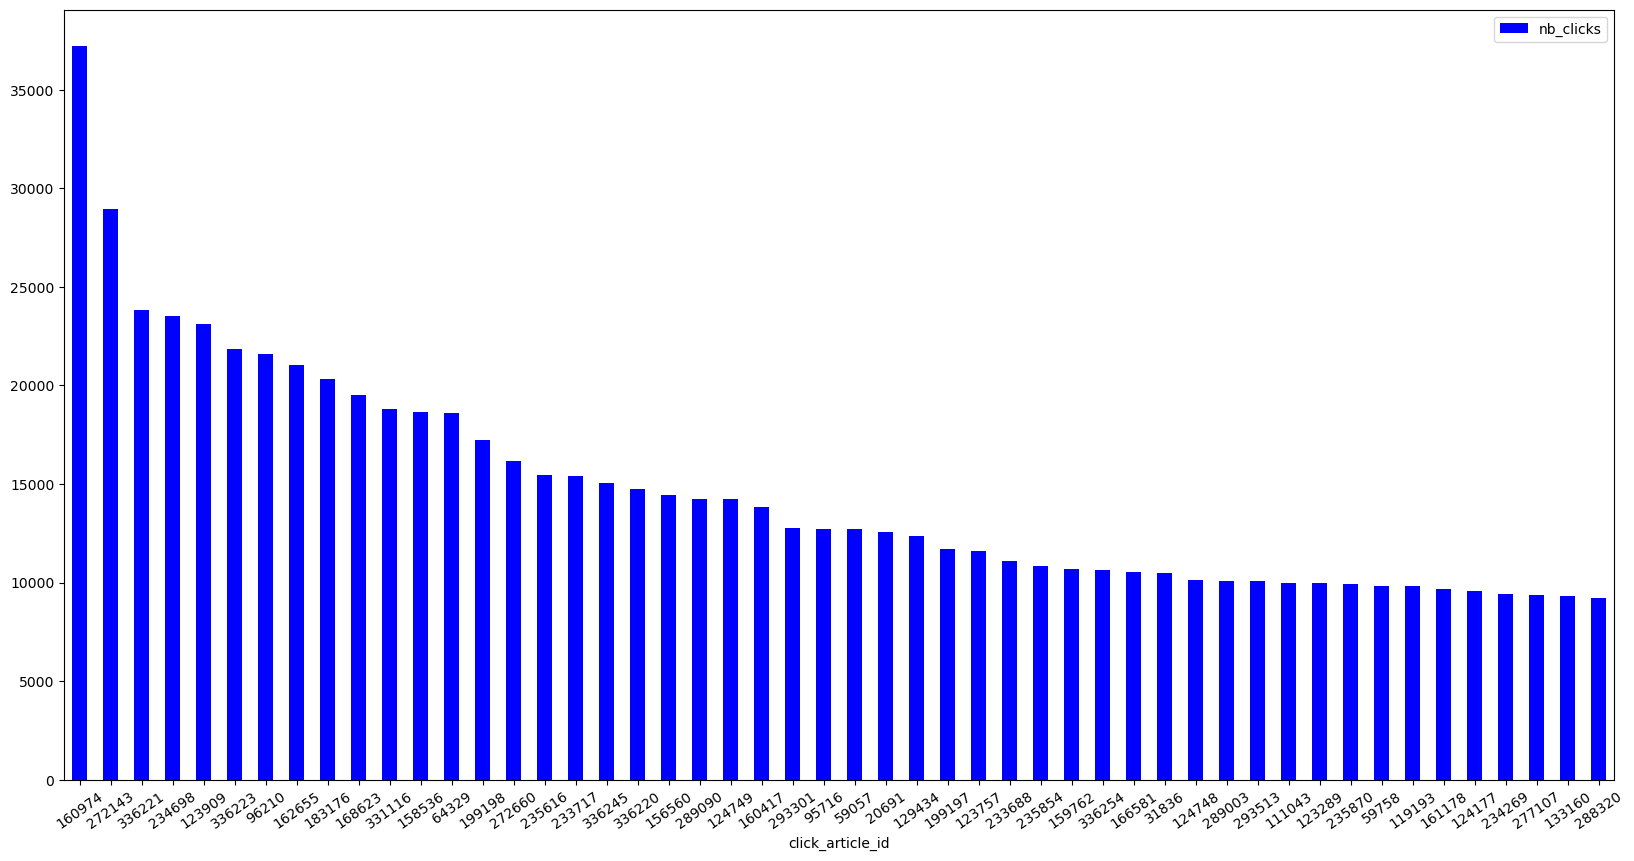

In [155]:
nb_clicks.plot.bar(x='click_article_id', y='nb_clicks', figsize=(20,10), color=('b'), rot=(35))

Ce graphe montre que dans le cas des modèles basés sur le filtrage collaboratif les articles fréquement recommandés ne sont pas les articles les plus lus.

# <span style='color:#DC6000 ' id="section_6" >6. Sauvegarde dans Azure</span>

In [109]:
# From azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
from azure.storage.blob import BlobClient

account_url = os.environ['AZURE_STORAGE_BLOB_ACCOUNT_URL']
creds = os.environ['AZURE_STORAGE_BLOB_CREDENTIAL']
#AZURE_STORAGE_BLOB_CREDENTIAL
service_client = BlobServiceClient(
    account_url = account_url,
    credential = creds
)

In [110]:
# controle contenaire
def get_containers():
    try:
        containers = service_client.list_containers()
        print([container.name for container in containers])
    except Exception as e:
        print(e.message)

get_containers()

['p9pickle']


In [111]:
def upload_to_azure(container_name, save_azure_name, path_file_name):
    blob_url = f"{account_url}/{container_name}/{save_azure_name}"
    blob_client = BlobClient.from_blob_url(blob_url=blob_url,credential=creds)
    with open(path_file_name, "rb") as blob_file:
        blob_client.upload_blob(data=blob_file,overwrite=True)
    print("Le fichier a été sauvegardé dans azure sous le mom : ",save_azure_name)

In [112]:
upload_to_azure('p9pickle','articles_embeddings.pickle','data/' + data_azure + '/articles_embeddings.pickle')

Le fichier a été sauvegardé dans azure sous le mom :  articles_embeddings.pickle


In [113]:
upload_to_azure('p9pickle','all_clicks.pickle','data/' + data_azure + '/all_clicks.pickle')

Le fichier a été sauvegardé dans azure sous le mom :  all_clicks.pickle


In [114]:
upload_to_azure('p9pickle','users.pickle','data/' + data_azure + '/users.pickle')

Le fichier a été sauvegardé dans azure sous le mom :  users.pickle


In [115]:
upload_to_azure('p9pickle','als_model.pickle','pickle_AlternatingLeastSquares.pkl')

Le fichier a été sauvegardé dans azure sous le mom :  als_model.pickle


In [130]:
upload_to_azure('p9pickle','ratings_sparse.npz','ratings_sparse.npz')

Le fichier a été sauvegardé dans azure sous le mom :  ratings_sparse.npz
